In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
import matplotlib.ticker as mtick
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2
from scipy.stats import multivariate_normal, norm
from os import listdir
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
%matplotlib inline

new_rc_params = {'text.usetex': False,
    "svg.fonttype": 'none'
    }
mpl.rcParams.update(new_rc_params)

In [135]:
#Voting history from all 51 'states' since 1976
votinghistory_full = np.loadtxt('1976-2020-president.csv', delimiter=',', skiprows=1, usecols=(0, 1, 10, 11, 14), 
                                dtype=[('year', int), ('state', 'U25'), ('votes', int), ('total_votes', int), 
                                       ('party', 'U20')])
print(votinghistory_full)

[(1976, 'ALABAMA', 659170, 1182850, 'DEMOCRAT')
 (1976, 'ALABAMA', 504070, 1182850, 'REPUBLICAN')
 (1976, 'ALABAMA',   9198, 1182850, 'OTHER') ...
 (2020, 'WYOMING',   1739,  278503, 'OTHER')
 (2020, 'WYOMING',    279,  278503, 'OTHER')
 (2020, 'WYOMING',   1459,  278503, 'OTHER')]


In [136]:
#Voting results from only Democratic and Republican candidates
index_dem = votinghistory_full['party'] == 'DEMOCRAT'
index_rep = votinghistory_full['party'] == 'REPUBLICAN'
votinghistory_dem = votinghistory_full[index_dem] # democrat results only
votinghistory_rep = votinghistory_full[index_rep] # republican results only
votinghistory = np.concatenate([votinghistory_dem, votinghistory_rep]) # combined results

In [137]:
#Array of states in alphabetical order
states = np.unique(votinghistory['state'])

In [138]:
# Now, considering all races between 1976 and 2016, we calculate the mean voteshare and variance for each state,
# for each party, along with the full covariance matrix

# This data forms the mean vector and covariance matrix for our multivariate normal prior

#Democrats
index_dem_2016 = votinghistory_dem['year'] != 2020
years = np.unique(votinghistory_dem[index_dem_2016]['year'])
votinghistory_dem_2016 = votinghistory_dem[index_dem_2016]
voteshare_dem = []

# Generates array of percentage of total votes received by democrat and republican candidates for each state
# in each election
for i in range(len(states)):
    state = states[i]
    index = votinghistory_dem_2016['state'] == str(state)
    array = votinghistory_dem_2016[index]
    out = []
    for j in range(len(years)):
        voteshare = array[j][2] / array[j][3]
        out.append(voteshare)
    voteshare_dem.append(out)
cov_dem = np.cov(voteshare_dem, bias = True, dtype=np.float64)
var_dem = np.diag(cov_dem)
mean_dem = np.mean(voteshare_dem, axis = 1)

#Republicans
index_rep_2016 = votinghistory_rep['year'] != 2020
years = np.unique(votinghistory_rep[index_rep_2016]['year'])
votinghistory_rep_2016 = votinghistory_rep[index_rep_2016]
voteshare_rep = []
for i in range(len(states)):
    state = states[i]
    index = votinghistory_rep_2016['state'] == str(state)
    array = votinghistory_rep_2016[index]
    out = []
    for j in range(len(years)):
        voteshare = array[j][2] / array[j][3]
        out.append(voteshare)
    voteshare_rep.append(out)
cov_rep = np.cov(voteshare_rep, bias = True)
var_rep = np.diag(voteshare_rep)
mean_rep = np.mean(voteshare_rep, axis = 1)

In [139]:
# Ingesting polling data from 2020 election
polling_averages = np.loadtxt('presidential_general_averages.csv', delimiter=',', skiprows = 1, usecols = (0, 1, 2, 3), 
                              dtype=[('candidate', 'U20'), ('date', 'U10'), ('approval', float), ('state', 'U25')])

index_biden = polling_averages['candidate'] == 'Joseph R. Biden Jr.'
index_trump = polling_averages['candidate'] == 'Donald Trump'
polls_biden = polling_averages[index_biden] # Biden's polling results
polls_trump = polling_averages[index_trump] # Trump's polling results

In [140]:
# Organizing polling data by state to establish covariance matrix for multivariate normal likelihood

states_lowercase = np.unique(polling_averages['state'])
polling_dates = np.unique(polling_averages['date']) # allows us to sort out missing polling data for each state

# Joe Biden
polls_biden_bystate = []
polls_biden_national = []
for i in range(len(states_lowercase)):
    state = states_lowercase[i]
    index = polls_biden['state'] == str(state)
    array = polls_biden[index]
    mean = np.mean(array['approval'])
    stdv = np.std(array['approval'])
    # Dataset includes additional data for districts in Maine and Nebraska which are ignored
    # in this model
    if state == 'ME-1':
        continue
    if state == 'ME-2':
        continue
    if state == 'NE-2':
        continue
    if state == 'National':
        polls_biden_national.append(array)
    # Process for simulating missing polling data - as described in Assumptions section of paper
    else:
        out = []
        for j in range(len(polling_dates)):
            date = polling_dates[j]
            datapoint = array[array['date'] == str(date)]
            if not datapoint.tolist():
                new_datapoint = np.random.normal(mean, stdv) * 0.01
                out.append(new_datapoint)
            else:
                out.append(datapoint['approval'][0] * 0.01)
        polls_biden_bystate.append(out)
polls_biden_cov = np.cov(polls_biden_bystate, bias = True)

# Donald Trump
polls_trump_bystate = []
polls_trump_national = []
for i in range(len(states_lowercase)):
    state = states_lowercase[i]
    index = polls_trump['state'] == str(state)
    array = polls_trump[index]
    mean = np.mean(array['approval'])
    stdv = np.std(array['approval'])
    if state == 'ME-1':
        continue
    if state == 'ME-2':
        continue
    if state == 'NE-2':
        continue
    if state == 'National':
        polls_trump_national.append(array)
    else:
        out = []
        for j in range(len(polling_dates)):
            date = polling_dates[j]
            datapoint = array[array['date'] == str(date)]
            if not datapoint.tolist():
                new_datapoint = np.random.normal(mean, stdv) * 0.01
                out.append(new_datapoint)
            else:
                out.append(datapoint['approval'][0] * 0.01)
        polls_trump_bystate.append(out)
polls_trump_cov = np.cov(polls_trump_bystate, bias = True)
print(len(polls_trump_cov))

51


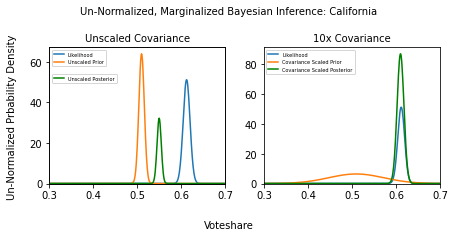

In [237]:
#Marginalized, un-normalized Gaussian likelihood, prior, and posterior distributions for Biden in California 

state = 'California'
index = polls_biden['state'] == str(state)
array = polls_biden[index]
mean = np.mean(array['approval'])
stdv = np.std(array['approval'])

x = np.linspace(0, 1, 1000)
factor = 10
like_calif_biden = norm.pdf(x, mean * 0.01, stdv * 0.01)
pri_calif_biden = norm.pdf(x, mean_dem[4], np.diag(cov_dem)[4])
pri_calif_biden_wide = norm.pdf(x, mean_dem[4], np.diag(cov_dem)[4] * factor)
post_calif_biden = like_calif_biden * pri_calif_biden
post_calif_biden_wide = like_calif_biden * pri_calif_biden_wide

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4, 4.8 / 1.5))

ax2 = ax[0].twinx()

ax[0].plot(x, like_calif_biden, label='Likelihood')
ax[0].plot(x, pri_calif_biden, label='Unscaled Prior')
ax2.plot(x, post_calif_biden, label='Unscaled Posterior', color='g')
ax2.set_ylim(0, 10 * 10**-20)
ax2.tick_params(axis='y', labelcolor='g')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax2.set_yticks(ticks = np.linspace(0, 10*10**-20, 0), fontsize=2)

ax[1].plot(x, like_calif_biden, label='Likelihood')
ax[1].plot(x, pri_calif_biden_wide, label='Covariance Scaled Prior')
ax[1].plot(x, post_calif_biden_wide, label='Covariance Scaled Posterior', color='g')
ax[1].set_ylim(0)
ax[0].set_ylim(0)

ax[0].set_xlim(0.3, 0.7)
ax[1].set_xlim(0.3, 0.7)
ax[0].set_title('Unscaled Covariance', fontsize=10)
ax[1].set_title('10x Covariance', fontsize=10)
ax[0].legend(loc='upper left', prop={'size': 5})
ax[1].legend(loc='upper left', prop={'size': 5})
ax2.legend(loc=(0.015, 0.74), prop={'size': 5})

fig.suptitle('Un-Normalized, Marginalized Bayesian Inference: California', fontsize=10)
fig.supxlabel('Voteshare', fontsize = 10)
fig.supylabel('Un-Normalized Prbability Density', fontsize = 10)
fig.tight_layout()
fig.savefig('Plots/marginalized_inference.png')
plt.show()

In [27]:
# Implementing MCMC
# First simulation done using computationally inefficient posterior (taking log after of post, rather than
# for likelihood and prior seperately). This is corrected for second simulation.

# Prior
def prior(mu, mu_0, sigma_0):
    return multivariate_normal.pdf(mu, mu_0, sigma_0, allow_singular = True)

# Likelihood
def likelihood(mu, polls, sigma):
    polls_l = np.asarray(polls).T
    index = len(polls_l)
    probs = []
    for i in range(index):
        prob = multivariate_normal.pdf(polls_l[i], mu, sigma, allow_singular = True)
        probs.append(prob)
    return np.prod(np.asarray(probs))

# Log Posterior
def log_post(mu, polls, sigma, mu_0, sigma_0):
    like = likelihood(mu, polls, sigma)
    pri = prior(mu, mu_0, sigma_0)
    post = like * pri
    if post > 0.:
        return np.log(post)
    else: return -np.inf

In [11]:
# First Democrat MCMC simulation
num_iter = 5000
ndim = 51
nwalkers = ndim * 2
# initial_pos taken to be mean vector from prior for both dems and reps
initial_pos = np.array(mean_dem) + 0.01 * np.random.randn(nwalkers, ndim)
print(initial_pos)
first_sampler_dem = emcee.EnsembleSampler(nwalkers, ndim, log_post, 
                                args=[polls_biden_bystate, polls_biden_cov, mean_dem, cov_dem])
first_sampler_dem.run_mcmc(initial_pos, num_iter, progress=True, skip_initial_state_check = True);

[[0.42520474 0.33287527 0.4128676  ... 0.44566045 0.47967173 0.30965349]
 [0.40870692 0.3443046  0.38407937 ... 0.46230026 0.48031373 0.31797789]
 [0.40896387 0.34439444 0.38378544 ... 0.45965944 0.48524805 0.29129935]
 ...
 [0.41078394 0.34186258 0.3992775  ... 0.44095992 0.49024675 0.3106862 ]
 [0.40400803 0.3463881  0.38893767 ... 0.45561336 0.4779559  0.31294965]
 [0.40860425 0.33135624 0.39597478 ... 0.48194661 0.48409191 0.29953037]]


100%|██████████| 5000/5000 [13:35:54<00:00,  9.79s/it]  


In [12]:
first_chain_dem = sampler.get_chain(discard=100, flat=True)
first_sim_dem = np.savetxt('first_sim_dem.csv', fist_chain_dem, delimiter=',')

In [19]:
# First Republican MCMC simulation
num_iter = 6000
ndim = 51
nwalkers = ndim * 2
initial_pos = np.array(mean_rep) + 0.01 * np.random.randn(nwalkers, ndim)
print(initial_pos)
first_sampler_rep = emcee.EnsembleSampler(nwalkers, ndim, log_post, 
                                args=[polls_trump_bystate, polls_trump_cov, mean_rep, cov_rep])
first_sampler_rep.run_mcmc(initial_pos, num_iter, progress=True, skip_initial_state_check = True);

In [19]:
first_chain_rep = first_sampler_rep.get_chain(discard=100, flat=True)
first_sim_rep = np.savetxt('first_sim_rep.csv', first_chain_rep, delimiter=',')

[[0.55523962 0.55695769 0.55068922 ... 0.50044312 0.44916211 0.61009249]
 [0.54879973 0.56505465 0.52262305 ... 0.50855211 0.4626784  0.62828517]
 [0.56191024 0.57802386 0.53386116 ... 0.49811526 0.46765806 0.61395844]
 ...
 [0.57009039 0.55590725 0.53823916 ... 0.49990054 0.47296965 0.61482714]
 [0.5718474  0.57211746 0.53854467 ... 0.50749413 0.44618822 0.6074123 ]
 [0.53561973 0.55344881 0.53014507 ... 0.48185114 0.44448659 0.60614581]]


100%|██████████| 6000/6000 [16:23:13<00:00,  9.83s/it]  


In [67]:
# We Assume the parameters are normally distributed and calculate the mean for each state

post_means_dem = np.mean(chain.T, axis = 1)
post_means_rep = np.mean(chain_rep.T, axis = 1)

In [86]:
print(post_means_dem), print(np.diag(polls_biden_cov))

[0.41290006 0.33749179 0.40400363 0.45489959 0.50828523 0.43689451
 0.49934962 0.50635809 0.85624576 0.45132726 0.46446453 0.55564273
 0.30997008 0.51770848 0.40990665 0.47777202 0.3724179  0.42501231
 0.4391345  0.47700307 0.54115442 0.55487454 0.48433898 0.50094545
 0.42429348 0.45472413 0.39790968 0.34289886 0.43224773 0.43399596
 0.49415709 0.47264786 0.52687932 0.45425312 0.36431379 0.45699774
 0.36166581 0.48276109 0.48844017 0.55694523 0.43315848 0.39680171
 0.44120895 0.41502303 0.2788869  0.51413735 0.4498181  0.48844773
 0.45190282 0.48365349 0.31263663]
[3.65110372e-05 4.59670361e-05 8.34598061e-05 8.02109770e-04
 6.06486014e-05 8.11046928e-04 4.05315464e-04 1.55826821e-04
 1.79899329e-04 8.00495725e-05 8.08491192e-05 8.90743475e-04
 1.90617786e-04 1.23535315e-04 7.32630638e-05 1.19508741e-04
 7.93706418e-05 3.01458066e-05 1.10262618e-04 1.14902062e-04
 9.21872676e-05 2.73233096e-04 1.48324006e-04 2.65743421e-04
 4.70783974e-05 9.25087465e-05 1.59294275e-03 9.19911687e-05
 1

(None, None)

In [28]:
import montecarlo
%load_ext autoreload
%autoreload 2

In [147]:
first_post_dem = np.loadtxt('first_sim_dem.csv', delimiter = ',')
first_post_rep = np.loadtxt('first_sim_rep.csv', delimiter=',')
first_dem_param_mean = np.mean(first_post_dem, axis = 0)
first_rep_param_mean = np.mean(first_post_rep, axis = 0)

In [40]:
print(len(dem_mean))
print(dem_mean)

51
[0.41290006 0.33749179 0.40400363 0.45489959 0.50828523 0.43689451
 0.49934962 0.50635809 0.85624576 0.45132726 0.46446453 0.55564273
 0.30997008 0.51770848 0.40990665 0.47777202 0.3724179  0.42501231
 0.4391345  0.47700307 0.54115442 0.55487454 0.48433898 0.50094545
 0.42429348 0.45472413 0.39790968 0.34289886 0.43224773 0.43399596
 0.49415709 0.47264786 0.52687932 0.45425312 0.36431379 0.45699774
 0.36166581 0.48276109 0.48844017 0.55694523 0.43315848 0.39680171
 0.44120895 0.41502303 0.2788869  0.51413735 0.4498181  0.48844773
 0.45190282 0.48365349 0.31263663]


In [66]:
runs = 100000
montecarlo_dem = montecarlo.montecarlo(runs, dem_mean, polls_biden_cov)

  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Dem Electoral College Outcome')

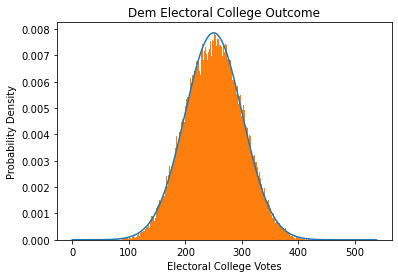

In [67]:
bins = np.linspace(0, 538, 539)

mu, sigma = norm.fit(montecarlo_dem[0])
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

plt.hist(montecarlo_dem[0], bins, density = True)
plt.xlabel('Electoral College Votes')
plt.ylabel('Probability Density')
plt.title('Dem Electoral College Outcome')

(0.42, 0.515)

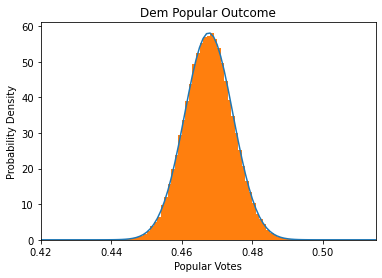

In [72]:
bins = np.linspace(0, 1, 1001)

mu, sigma = norm.fit(montecarlo_dem[4])
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

plt.hist(montecarlo_dem[4], bins, density = True)
plt.xlabel('Popular Votes')
plt.ylabel('Probability Density')
plt.title('Dem Popular Outcome')
plt.xlim(0.42, 0.515)

## Second Simulation with Historical Covariance

In [141]:
## Revised MCMC

# Prior
def prior(mu, mu_0, sigma_0):
    return multivariate_normal.logpdf(mu, mu_0, sigma_0, allow_singular = True)

# Likelihood
def likelihood(mu, polls, sigma):
    polls_l = np.asarray(polls).T
    index = len(polls_l)
    probs = []
    for i in range(index):
        prob = multivariate_normal.logpdf(polls_l[i], mu, sigma, allow_singular = True)
        probs.append(prob)
    return np.sum(np.asarray(probs))

# Posterior
def log_post(mu, polls, sigma, mu_0, sigma_0):
    like = likelihood(mu, polls, sigma)
    pri = prior(mu, mu_0, sigma_0)
    if (not np.isfinite(like))|(not np.isfinite(pri)):
        return -np.inf
    return like + pri

In [145]:
revised_cov_dem = cov_dem * 10

# MCMC
num_iter = 9000
ndim = 51
nwalkers = ndim * 2
initial_pos = np.array(mean_dem) + 0.01 * np.random.randn(nwalkers, ndim)
print(initial_pos)
second_chain_dem = emcee.EnsembleSampler(nwalkers, ndim, log_post, 
                                args=[polls_biden_bystate, polls_biden_cov, mean_dem, revised_cov_dem])
second_chain_dem.run_mcmc(initial_pos, num_iter, progress=True, skip_initial_state_check = True);

second_sim_dem = second_chain_dem.get_chain(discard=100, flat=True)
second_sim = np.savetxt('second_sim_dem.csv', second_sim_dem, delimiter=',')

[[0.4392366  0.34625572 0.40427911 ... 0.46027601 0.47181594 0.30722966]
 [0.40999391 0.33388349 0.40032938 ... 0.4374095  0.48171183 0.30601215]
 [0.41622878 0.32582881 0.40253035 ... 0.46829844 0.48763888 0.31088104]
 ...
 [0.40503944 0.34635385 0.39262863 ... 0.45658329 0.47764664 0.30792977]
 [0.42560528 0.33805669 0.39724931 ... 0.44196414 0.48528171 0.3158685 ]
 [0.42857886 0.32931733 0.39899543 ... 0.43984558 0.51209225 0.31903209]]


100%|██████████| 9000/9000 [25:04:17<00:00, 10.03s/it]      
